In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels.api as sm

In [53]:
import numba as nb
import arch

In [54]:
import plotter.activate
from plotter import plot

In [12]:
rng = np.random.default_rng()

### Data

In [13]:
n_dates = 5000
dates = pd.date_range('2010-01-01', periods=n_dates)
arr = rng.standard_normal(size=(n_dates, 5))
corr = sp.stats.random_correlation.rvs(5*np.arange(1,6)/15)
df = pd.DataFrame(arr.dot(corr), columns=list('abcde'), index=dates)

In [14]:
df.corr()

,a,b,c,d,e
a,1.000000,-0.505333,0.236836,0.432212,-0.164773
b,-0.505333,1.000000,-0.633757,-0.056438,0.555875
c,0.236836,-0.633757,1.000000,-0.373172,-0.176642
d,0.432212,-0.056438,-0.373172,1.000000,0.298478
e,-0.164773,0.555875,-0.176642,0.298478,1.000000


In [15]:
white_noise = df['a']
white_noise_lagged = pd.concat([white_noise.shift(i).fillna(0) for i in range(1, 11)], axis=1)
coefs = np.hstack([np.arange(5, 0, -1)*0.05, np.arange(5, 0, -1)*0.03])
ar_ser = white_noise + white_noise_lagged.mul(coefs, axis=1).sum(1)

In [16]:
ar_ser

2010-01-01    0.223314
2010-01-02   -0.933886
2010-01-03   -1.843478
2010-01-04    0.277069
2010-01-05    0.822486
                ...   
2023-09-05   -1.669836
2023-09-06    0.696933
2023-09-07   -0.830086
2023-09-08    1.009595
2023-09-09    0.648981
Freq: D, Length: 5000, dtype: float64

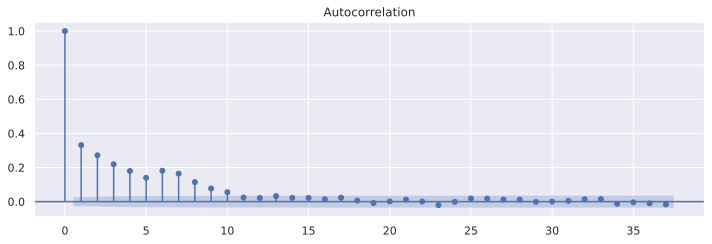

In [17]:
with plot(wide=True, legend=False) as p:
    sm.graphics.tsa.plot_acf(ar_ser, ax=p.ax());

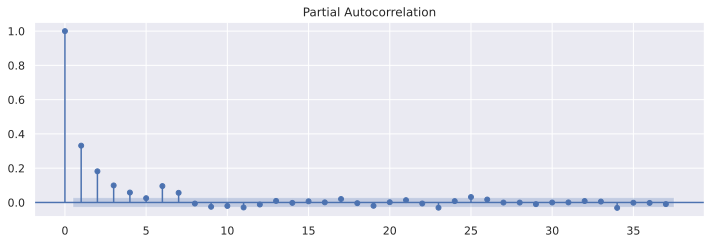

In [18]:
with plot(wide=True, legend=False) as p:
    sm.graphics.tsa.plot_pacf(ar_ser, ax=p.ax());

In [19]:
ar_ser_lagged = pd.concat([ar_ser.shift(i) for i in range(1, 11)], axis=1).fillna(0)
fit_res = sm.OLS(ar_ser, ar_ser_lagged).fit()
resid = ar_ser - fit_res.predict(ar_ser_lagged)

In [20]:
resid

2010-01-01    0.223314
2010-01-02   -0.987049
2010-01-03   -1.652581
2010-01-04    0.830750
2010-01-05    1.077504
                ...   
2023-09-05   -1.270234
2023-09-06    1.222900
2023-09-07   -0.682469
2023-09-08    1.294559
2023-09-09    0.665335
Freq: D, Length: 5000, dtype: float64

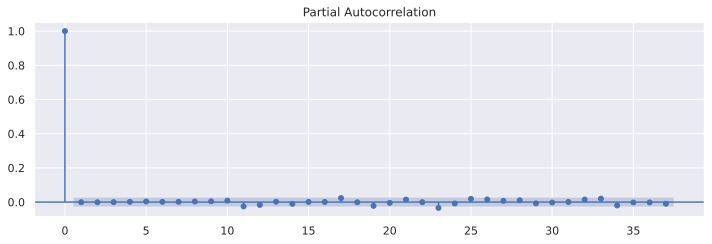

In [21]:
with plot(wide=True, legend=False) as p:
    sm.graphics.tsa.plot_pacf(resid, ax=p.ax());

In [22]:
sm.stats.diagnostic.acorr_ljungbox(resid, lags=[20], return_df=True)

,lb_stat,lb_pvalue
20,11.083991,0.944015


In [23]:
fit_res = sm.tsa.arima.ARIMA(ar_ser, order=(5, 0, 10)).fit()

/home/vlad/miniconda3/envs/research/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
fit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:                ARIMA(5, 0, 10)   Log Likelihood               -7521.970
Date:                Wed, 16 Dec 2020   AIC                          15077.941
Time:                        15:52:41   BIC                          15188.733
Sample:                    01-01-2010   HQIC                         15116.772
                         - 09-09-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0263      0.036     -0.729      0.466      -0.097       0.044
ar.L1         -0.3317      0.350     -0.949      0.343      -1.017       0.353
ar.L2         -0.5484      0.290     -1.894      0.058      -1.116       0.019
ar.L3          0.0229      0.298      0.077      0.939      -0.562       0.608
ar.L4          0.2829      0.273      1.035      0.301      -0.253       0.818
ar.L5          0.1360      0.214      0.635      0.526      -0.284       0.556
ma.L1          0.5698      0.349      1.632      0.103      -0.114       1.254
ma.L2          0.8263      0.262      3.149      0.002       0.312       1.341
ma.L3          0.3304      0.311      1.063      0.288      -0.279       0.939
ma.L4         -0.0082      0.239     -0.034      0.973      -0.476       0.460
ma.L5         -0.0128      0.165     -0.077      0.938      -0.337       0.311
ma.L6          0.1364      0.036      3.762      0.000       0.065       0.207
ma.L7          0.1489      0.046      3.234      0.001       0.059       0.239
ma.L8          0.1591      0.035      4.572      0.000       0.091       0.227
ma.L9          0.1323      0.035      3.759      0.000       0.063       0.201
ma.L10         0.0761      0.028      2.694      0.007       0.021       0.131
sigma2         1.1861      0.024     50.078      0.000       1.140       1.233
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.30
Prob(Q):                              0.96   Prob(JB):                         0.32
Heteroskedasticity (H):               1.03   Skew:                             0.05
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
sm.stats.diagnostic.acorr_ljungbox(fit_res.resid, lags=[45], return_df=True)

,lb_stat,lb_pvalue
45,28.849403,0.970671


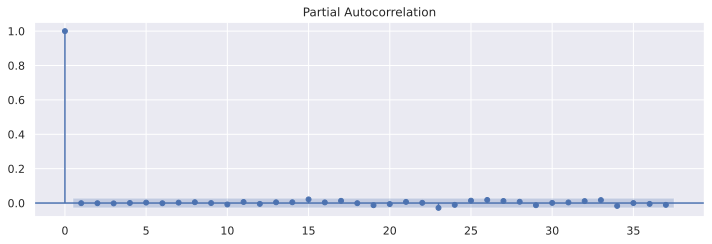

In [26]:
with plot(wide=True, legend=False) as p:
    sm.graphics.tsa.plot_pacf(fit_res.resid, ax=p.ax());

In [65]:
sm.stats.diagnostic.acorr_ljungbox(white_noise, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,1.716254,0.886846


In [74]:
# unit root test
ad_fuller_pvalue = sm.tsa.stattools.adfuller(ar_ser)[1]

## GARCH test

In [62]:
@nb.njit
def generate_vol(mean_vol, white_noise, a, b):
    vol = np.zeros(n_dates)
    vol[0] = mean_vol
    for i in range(1, len(vol)):
        vol[i] = a*white_noise[i]**2 + b*vol[i-1] + (1 - a - b)*mean_vol
    return vol

In [77]:
mean_vol = 0.1
a = 0.25
b = 0.5

vol = pd.Series(generate_vol(mean_vol, white_noise.values, a, b), index=dates)

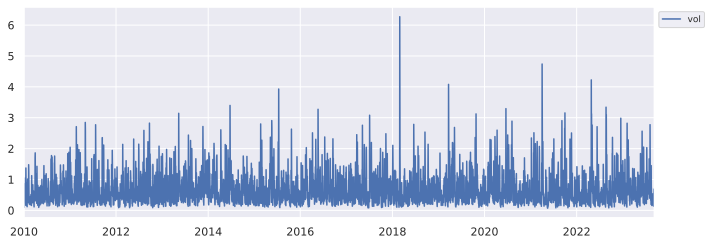

In [79]:
with plot(wide=True):
    vol.plot(label='vol')

In [80]:
garch_ser = vol*white_noise

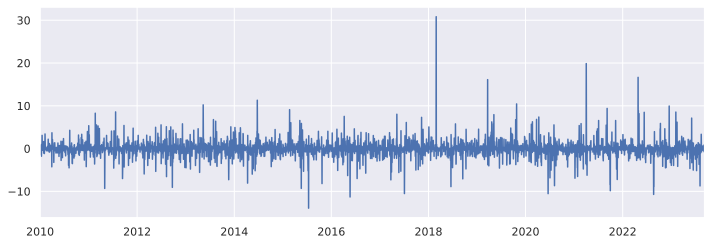

In [81]:
with plot(wide=True, legend=False):
    garch_ser.plot()

In [82]:
garch = arch.arch_model(garch_ser, vol='garch', p=1, o=0, q=1)

In [83]:
garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31941.510359382093
Iteration:      2,   Func. Count:     14,   Neg. LLF: 31567.00858624059
Iteration:      3,   Func. Count:     22,   Neg. LLF: 9504.731185190947
Iteration:      4,   Func. Count:     28,   Neg. LLF: 9465.469147077643
Iteration:      5,   Func. Count:     34,   Neg. LLF: 9463.173083228303
Iteration:      6,   Func. Count:     40,   Neg. LLF: 9448.55409389051
Iteration:      7,   Func. Count:     46,   Neg. LLF: 9447.867950540951
Iteration:      8,   Func. Count:     51,   Neg. LLF: 9447.865140938819
Iteration:      9,   Func. Count:     56,   Neg. LLF: 9447.865055827267
Iteration:     10,   Func. Count:     61,   Neg. LLF: 9447.865046753379
Iteration:     11,   Func. Count:     65,   Neg. LLF: 9447.865046753004
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9447.865046753379
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -9447.87
Distribution:                  Normal   AIC:                           18903.7
Method:            Maximum Likelihood   BIC:                           18929.8
                                        No. Observations:                 5000
Date:                Wed, Dec 16 2020   Df Residuals:                     4996
Time:                        16:10:48   Df Model:                            4
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0214  2.285e-02      0.935      0.350 

## sklearn 

In [87]:
import sklearn.linear_model as lm